# Basic Design

**Question:**
Take a look at the map and derive distances (min, max) and angles (horizontal and vertical).

**Question:**
Make a drawing showing the center lines and edge angles. 

In [1]:
import math
import folium
import numpy as np
from geopy.distance import distance

In [2]:
antenna_building_height_m = 20

antenna_coordinates = [51.225779846347535, 4.400503131269632]
min_site_coordinates = [51.227090, 4.393261]
max_site_coordinates = [51.227990333375544, 4.389441701586266]
min_site_north_coordinates = [51.22979961685109, 4.394331930457293]
min_site_south_coordinates = [51.22466615115592, 4.391886179162105]

In [3]:
map = folium.Map(location=min_site_coordinates, zoom_start=15)

antenna_marker = folium.Marker(location=antenna_coordinates, popup="antenna")
min_site_marker = folium.Marker(location=min_site_coordinates, popup="min site")
max_site_marker = folium.Marker(location=max_site_coordinates, popup="max site")
min_site_north_marker = folium.Marker(location=min_site_north_coordinates, popup="min site north")
min_site_south_marker = folium.Marker(location=min_site_south_coordinates, popup="min site south")

antenna_marker.add_to(map)
min_site_marker.add_to(map)
max_site_marker.add_to(map)
min_site_north_marker.add_to(map)
min_site_south_marker.add_to(map)

map

## Horizontal Angle 

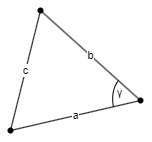

Law of cosines
$$ \gamma = \arccos\left(\frac{a^2+b^2-c^2}{2ab}\right) $$

In [4]:
def get_horizontal_angle():
    a = distance(antenna_coordinates, min_site_south_coordinates).m
    b = distance(antenna_coordinates, min_site_north_coordinates).m
    c = distance(min_site_south_coordinates, min_site_north_coordinates).m
    
    return math.acos((a**2 + b**2 - c**2) / (2*a*b))

In [5]:
horizontal_angle = get_horizontal_angle()

print(f'horizontal angle: {horizontal_angle:.2f} radians')

horizontal angle: 1.01 radians


## Vertical Angle

### Naive Vertical Angle

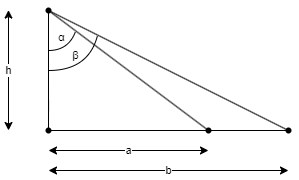

$$ tan(\alpha) = \frac{a}{h} $$
$$ tan(\beta) = \frac{b}{h} $$
$$ \rightarrow \beta - \alpha $$

In [6]:
def get_vertical_angle():
    a = distance(antenna_coordinates, min_site_coordinates).m
    b = distance(antenna_coordinates, max_site_coordinates).m
    h = antenna_building_height_m
    
    alpha = math.atan(a/h)
    beta = math.atan(b/h)
    
    return beta - alpha

In [7]:
vertical_angle = get_vertical_angle()

print(f'vertical angle: {vertical_angle:.2f} radians')

vertical angle: 0.01 radians


### Vertical Angle including Heigth

In [8]:
import requests
import pandas as pd
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def get_elevation(coordinates):
    lat, long = coordinates
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    r = requests.get(query, verify=False).json()
    elevation = r['results'][0]['elevation']
    return elevation

In [9]:
building_elevation_m = get_elevation(antenna_coordinates)
antenna_elevation_m = building_elevation_m + antenna_building_height_m

max_site_elevation_m = get_elevation(max_site_coordinates)
min_site_elevation_m = get_elevation(min_site_coordinates)

print(f'building elevation: {building_elevation_m:.2f} m')
print(f'antenna elevation: {antenna_elevation_m:.2f} m')
print(f'max site elevation: {max_site_elevation_m:.2f} m')
print(f'min site elevation: {min_site_elevation_m:.2f} m')

building elevation: 11.00 m
antenna elevation: 31.00 m
max site elevation: 9.00 m
min site elevation: 5.00 m


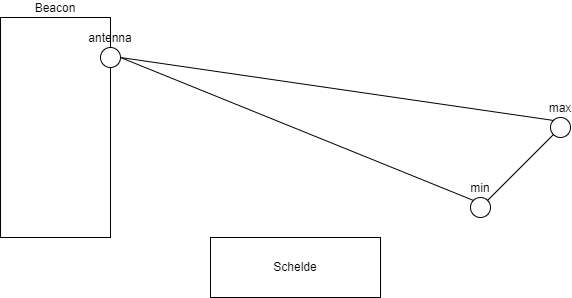

## Video Bandwidth

**Question:** Calculate the needed bandwidth to reliably stream a 4K image. Document your assumptions in terms of compression.

Data Rate = Resolution $\times$ Frame Rate $\times$ Color Depth $\times$ Compression Ratio
```
- Data Rate   [bits/seconds]
- Resolution  [pixels/frame]
- Frame Rate  [frames/second]
- Color Depth [bits/pixel]
- Compression Ratio
```

Assume a compression ratio of 1/150

**Sources:**
- The recommend internet connection speed for playing 4K video from netflix is 15 Mbps
    - https://help.netflix.com/en/node/306

In [10]:
def get_data_rate_bps(resolution, frame_rate, color_depth, compression_ratio):
    return resolution * frame_rate * color_depth * compression_ratio

target_data_rate_bps = get_data_rate_bps(
    resolution=3840 * 2160,
    frame_rate=30,
    color_depth=10,
    compression_ratio=1/150
)

target_data_rate_mbps = target_data_rate_bps / 1_000_000

print(f'target data rate: {target_data_rate_mbps:.2f} Mbps')

target data rate: 16.59 Mbps


**Question:** Break down the terms contributing to the e2e latency of your systems (from video capture to playback). 

**Answer:**

- Capture Latency: The time it takes for the camera to capture the video frames and send them to the encoder.

- Encoding Latency: The time it takes for the video to be encoded by the video encoder.

- Transmission Latency: The time it takes for the encoded video to be transmitted over the network to the viewer's device.

- Decoding Latency: The time it takes for the video to be decoded by the viewer's device.

- Display Latency: The time it takes for the decoded video to be displayed on the viewer's screen.

**Sources:**
- ChatGPT Mar 23 Version

**Question:** Make a choice as to which latency you are willing to accept. Why?

**Answer:**
Different use cases have varying levels of acceptable latency.

| Latency | Use Case                         |
|---------|----------------------------------|
| 45 s    | Conference Video Broadcasts      |
| 5 s     | Consumer IP Cameras, Live Sports |
| 500 ms  | Online auctions, security camera |
| 200 ms  | VOIP, video chat                 |

Our use case aligns best with the 500 ms latency.

**Sources:**
- https://www.rhombus.com/blog/guide-to-ultra-low-latency-ip-cameras-for-live-video-streaming/
- https://www.worldcast.group/low-latency-video-communication/

**Question:** Do you have requirements wrt. packet loss? Why?

**Answer:**

| Loss    | Rating     |
|---------|------------|
| <1%     | good       |
| 1%-2.5% | acceptable |
| 2.5%-5% | poor       |

I believe an "acceptable" rating to be reasonable.
So we aim for a maximum of 2.5% packet loss.

**Sources:**
- https://web.archive.org/web/20131010010244/http://sdu.ictp.it/pinger/pinger.html
